In [1]:
# SAM visualization with PLT

import matplotlib.pyplot as plt
import numpy as np

################## SAM functions ############################
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

/home/wpals113/.conda/envs/openmmlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.95972633]
[0.95972633, 0.34794062]
[0.95972633, 0.34794062, 0.56831247]
[0.95972633, 0.34794062, 0.56831247, 0.7945639]
[0.95972633, 0.34794062, 0.56831247, 0.7945639, 0.9446744]
[0.95972633, 0.34794062, 0.56831247, 0.7945639, 0.9446744, 0.55818254]
[0.95972633, 0.34794062, 0.56831247, 0.7945639, 0.9446744, 0.55818254, 0.35718012]
[0.95972633, 0.34794062, 0.56831247, 0.7945639, 0.9446744, 0.55818254, 0.35718012, 0.45767456]
[0.2588669]
[0.2588669, 0.95972633]
[0.2588669, 0.95972633, 0.9446744]
[0.2588669, 0.95972633, 0.9446744, 0.54882294]
[0.2588669, 0.95972633, 0.9446744, 0.54882294, 0.5143223]
[0.2588669, 0.95972633, 0.9446744, 0.54882294, 0.5143223, 0.8088748]
[0.2588669, 0.95972633, 0.9446744, 0.54882294, 0.5143223, 0.8088748, 0.4215671]
[0.2588669, 0.95972633, 0.9446744, 0.54882294, 0.5143223, 0.8088748, 0.4215671, 0.5073436]
[0.2588669, 0.95972633, 0.9446744, 0.54882294, 0.5143223, 0.8088748, 0.4215671, 0.5073436, 0.80114955]
[0.2588669, 0.95972633, 0.9446744, 0.54882294, 0.5

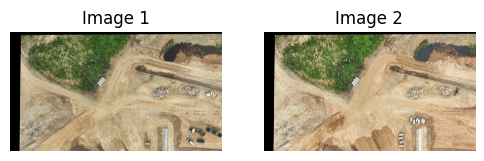

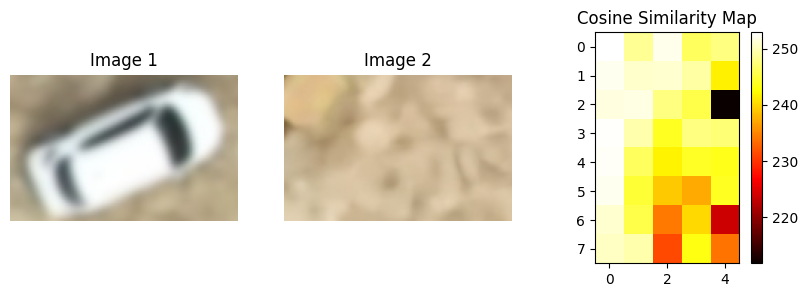

In [ ]:
# pixel-wise cosine-similarity test
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry

def normalize_vector(vector):
    """벡터를 정규화하는 함수"""
    norm = np.linalg.norm(vector, axis=0, keepdims=True)
    return vector / (norm + 1e-8)  # 0으로 나누는 것을 방지하기 위해 작은 값을 더함

def crop_and_resize(image, x1, x2, y1, y2):
    """이미지를 자르고 정사각형으로 리사이즈하는 함수"""
    crop = image[y1:y2, x1:x2]
    width = x2 - x1
    height = y2 - y1
    min_dim = min(width, height)
    return cv2.resize(crop, (min_dim, min_dim))

def cosine_similarity(embed1, embed2):
    # embed의 shape: (256, 64, 64)

    # 이미지를 float 타입으로 변환하고 정규화
    embed1 = embed1.astype(np.float32)
    embed2 = embed2.astype(np.float32)
    
    
    # 벡터 정규화
    norm_vector1 = normalize_vector(embed1)
    norm_vector2 = normalize_vector(embed2)
    
    # 코사인 유사도 계산
    cosine_similarity_map = np.sum(norm_vector1 * norm_vector2, axis=0)
    return cosine_similarity_map

def box_cosine_similarity(new_embed: np.ndarray, render_embed: np.ndarray, boxes: list, width: int, height: int, res_embed: int = 64) -> tuple:    

    cos_sim = [] 
    cos_sim_map = []
    for box in boxes:
        cls, x1, y1, x2, y2 = box
        
        x1, x2 = map(lambda p: int(p / width * res_embed), [x1, x2])
        y1, y2 = map(lambda p: int(p / height * res_embed), [y1, y2])

        x1_pad, y1_pad = map(lambda p: max(p - 1, 0), [x1, y1])
        x2_pad = min(x2+1, res_embed - 1)
        y2_pad = min(y2+1, res_embed - 1)

        embed1 = new_embed[..., y1_pad:y2_pad, x1_pad:x2_pad] # embedding shape: (C, H, W)
        embed2 = render_embed[..., y1_pad:y2_pad, x1_pad:x2_pad]
        
        cosine_similarity_map = cosine_similarity(embed1, embed2)        
        logits = np.mean(cosine_similarity_map)
        
        # if the box identifies change in the box
        
        cos_sim.append(logits)
        cos_sim_map.append(cosine_similarity_map)
        print(cos_sim)
    return cos_sim, cos_sim_map

def raw_to_sam_scale(coord:list, width:int, height: int, res_sam: int = 1024) -> list:
    x1, y1, x2, y2 = coord
    x1, x2 = map(lambda p: int(p /width * res_sam), [x1, x2])
    y1, y2 = map(lambda p: int(p /height * res_sam), [y1, y2])

    return [x1, y1, x2, y2]

# 사용자 설정
sam_checkpoint = "/workspace/Laboratory/04.model/segment_anything1/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
res_embed = 64

new_image_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Duraemidam_ChangeDetection_workspace/trial4/CD_PAIR/cd_pair_rectified/new_frame_00005.jpg"
render_image_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Duraemidam_ChangeDetection_workspace/trial4/CD_PAIR/cd_pair_rectified/initial_paired_frame_00005.jpg"
new_pred_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/outputs/new_pred/frame_00010.txt"
render_pred_path  = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/outputs/render_pred/frame_00010.txt"


# SAM 설정
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor1 = SamPredictor(sam) 
predictor2 = SamPredictor(sam) 


new_image = cv2.imread(new_image_path)
render_image = cv2.imread(render_image_path)


new_image_sam = cv2.resize(new_image, (1024, 1024))
render_image_sam = cv2.resize(render_image, (1024, 1024))

predictor1.set_image(new_image_sam) # 이미지 임베딩을 생성하기 위해 이미지 처리
predictor2.set_image(render_image_sam)
new_embed =  predictor1.features.squeeze().cpu().numpy()
render_embed = predictor2.features.squeeze().cpu().numpy()

height, width, _ = new_image.shape

in_boxes = []
with open(new_pred_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        
        # 바운딩 박스 정보 추출
        cls, conf, x1_r, y1_r, x2_r, y2_r = map(float, line.split(' '))
        cls = int(cls)

        x1, x2 = map(lambda p: int(p * width), [x1_r, x2_r])
        y1, y2 = map(lambda p: int(p * height), [y1_r, y2_r])
        
        in_boxes.append([cls, x1, y1, x2, y2])

out_boxes = []
with open(render_pred_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        
        # 바운딩 박스 정보 추출
        cls, conf, x1_r, y1_r, x2_r, y2_r = map(float, line.split(' '))
        cls = int(cls)

        x1, x2 = map(lambda p: int(p * width), [x1_r, x2_r])
        y1, y2 = map(lambda p: int(p * height), [y1_r, y2_r])
        
        out_boxes.append([cls, x1, y1, x2, y2])


cos_sim_in, cos_sim_map_in = box_cosine_similarity(new_embed, render_embed, in_boxes, width, height, res_embed)
cos_sim_out, cos_sim_map_out = box_cosine_similarity(new_embed, render_embed, out_boxes, width, height, res_embed)

print("debut detection")
in_masks = []
pop_idx = []
for idx, cos_sim in enumerate(cos_sim_in):
    if(cos_sim > 0.76):        
        pop_idx.append(idx)
        continue

    print(f"index: {idx}")
    cls, x1, y1, x2, y2 = in_boxes[idx]
    x1, y1, x2, y2 = raw_to_sam_scale([x1,y1,x2,y2], width, height, 1024)
    
    input_box = np.array([x1, y1, x2, y2])

    masks_in, scores, logits = predictor1.predict(    
    box=input_box[None, :],
    multimask_output=True    
    )
    in_masks.append(masks_in)    

if(len(pop_idx) != 0):
    for idx in reversed(pop_idx):
        in_boxes.pop(idx)    

print("retirement detection")
out_masks = []
pop_idx = []
for idx, cos_sim in enumerate(cos_sim_out):    
    if(cos_sim > 0.76):
        pop_idx.append(idx)
        continue

    print(f"index: {idx}")
    cls, x1, y1, x2, y2 = out_boxes[idx]
    x1, y1, x2, y2 = raw_to_sam_scale([x1,y1,x2,y2], width, height, 1024)
    
    input_box = np.array([x1, y1, x2, y2])

    masks_out, scores_out, logits_out = predictor2.predict(    
    box=input_box[None, :],
    multimask_output=True
    )    
    out_masks.append(masks_out) 

if(len(pop_idx) != 0):
    for idx in reversed(pop_idx):
        out_boxes.pop(idx)      

# plt 이미지 시각화를 위한 준비
plt_image1 = new_image
plt_image2 = render_image
# changed_box_idx = cos_sim_in.index(min(cos_sim_in))    
changed_box_idx = 0
cls, x1, y1, x2, y2 = in_boxes[changed_box_idx]
crop_new_image = new_image[y1:y2, x1:x2]
crop_render_image = render_image[y1:y2, x1:x2]
plt_image3 = crop_new_image
plt_image4 = crop_render_image
plt_image5 = (cos_sim_map_in[changed_box_idx]*255)

output_dir = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/temp_figures"
plt_path1 = os.path.join(output_dir, "img1.jpg")
plt_path2 = os.path.join(output_dir, "img2.jpg")
plt_path3 = os.path.join(output_dir, "img3.jpg")
cv2.imwrite(plt_path1, plt_image3)
cv2.imwrite(plt_path2, plt_image4)
cv2.imwrite(plt_path3, plt_image5)

plt_image1= cv2.cvtColor(plt_image1, cv2.COLOR_RGB2BGR)
plt_image2= cv2.cvtColor(plt_image2, cv2.COLOR_RGB2BGR)
plt_image3= cv2.cvtColor(plt_image3, cv2.COLOR_RGB2BGR)
plt_image4= cv2.cvtColor(plt_image4, cv2.COLOR_RGB2BGR)


# 시각화
plt.figure(figsize=(6, 3))

# 원본 이미지 1
plt.subplot(1, 2, 1)

plt.imshow(plt_image1)
plt.title("Image 1")
plt.axis('off')

# 원본 이미지 2
plt.subplot(1, 2, 2)
plt.imshow(plt_image2)
plt.title("Image 2")
plt.axis('off')

plt.show()

plt.figure(figsize=(10, 3))

# 원본 이미지 1
plt.subplot(1, 3, 1)
plt.imshow(plt_image3)
plt.title("Image 1")
plt.axis('off')

# 원본 이미지 2
plt.subplot(1, 3, 2)
plt.imshow(plt_image4)
plt.title("Image 2")
plt.axis('off')

# 코사인 유사도 맵
plt.subplot(1, 3, 3)
plt.imshow(plt_image5 , cmap='hot')
plt.title("Cosine Similarity Map")
plt.colorbar()

plt.show()


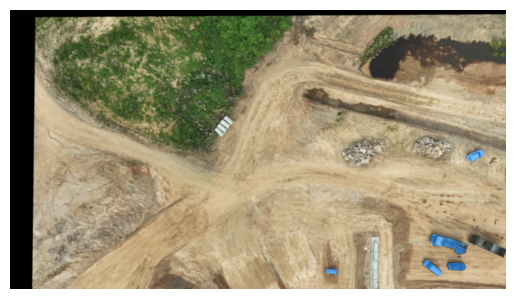

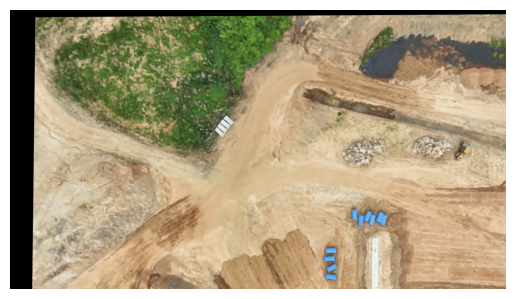

1


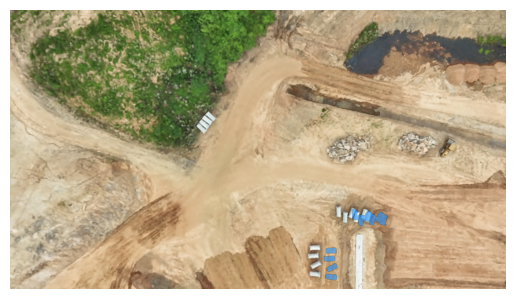

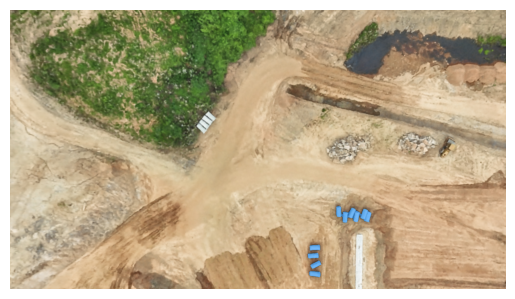

In [3]:
from PIL import Image
import json
plt_image7 = cv2.cvtColor(new_image_sam, cv2.COLOR_RGB2BGR)
in_mask_images = map(lambda masks: cv2.resize(masks[0].astype(np.uint8), (width, height)), in_masks)
plt_image8 = cv2.cvtColor(render_image_sam, cv2.COLOR_RGB2BGR)
out_mask_images = map(lambda masks: cv2.resize(masks[0].astype(np.uint8), (width, height)), out_masks)


in_change_mask = np.zeros((height, width),dtype = np.uint8)
for mask_image in in_mask_images:    
    in_change_mask = np.bitwise_or(in_change_mask, mask_image)
    # show_mask(mask_image, plt.gca())

plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
plt.axis('off')
show_mask(in_change_mask, plt.gca())
plt.show()

out_change_mask = np.zeros((height, width),dtype = np.uint8)
for mask_image in out_mask_images:
    out_change_mask = np.bitwise_or(out_change_mask, mask_image)

    
plt.imshow(cv2.cvtColor(render_image, cv2.COLOR_RGB2BGR))
show_mask(out_change_mask, plt.gca())
# show_box(input_box, plt.gca())
plt.axis('off')
plt.show()


# mask save
output_dir_in = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/sam/new_in_mask_pred"
output_dir_out = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/sam/render_out_mask_pred"
json_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/rectified/homography.json"
os.makedirs(output_dir_in, exist_ok=True)
os.makedirs(output_dir_out, exist_ok=True)


with open(json_path, "r") as f:
    data = json.load(f)

for line in data["homography"]:
    if(line["frame"] == "frame_00010"):
        print(1)
        homo = line["mat"]



out_mask_warped = cv2.warpPerspective(out_change_mask, np.linalg.inv(homo), (width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=0)   
# in_mask_image.save(os.path.join(output_dir_in, os.path.basename(new_image_path)))
# out_mask_image.save(os.path.join(output_dir_out, os.path.basename(render_image_path)))

# visualization
plt_image1 = cv2.imread("/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/new/renders/frame_00010.jpg")
plt_image1 = cv2.cvtColor(plt_image1, cv2.COLOR_RGB2BGR)
plt.imshow(plt_image1)
plt.axis('off')
show_mask(out_change_mask, plt.gca())
plt.show()
plt.imshow(plt_image1)
plt.axis('off')
show_mask(out_mask_warped, plt.gca())
plt.show()

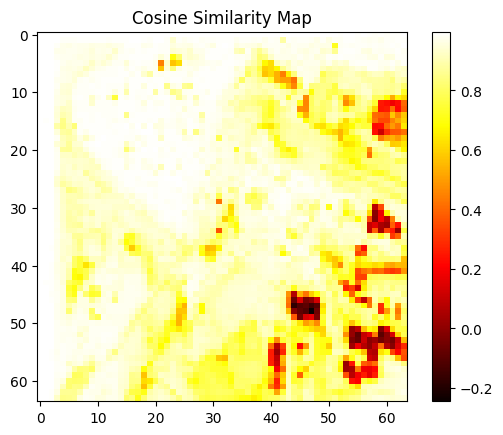

In [71]:
plt_image6 = cosine_similarity(new_embed, render_embed)
plt.imshow(plt_image6 , cmap='hot')
plt.title("Cosine Similarity Map")
plt.colorbar()
plt.show()


In [ ]:
# Pixel-based(No Object Detection) Version(2025.04.25)
 
 # pixel-wise cosine-similarity test
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry

def normalize_vector(vector):
    """벡터를 정규화하는 함수"""
    norm = np.linalg.norm(vector, axis=0, keepdims=True)
    return vector / (norm + 1e-8)  # 0으로 나누는 것을 방지하기 위해 작은 값을 더함

def crop_and_resize(image, x1, x2, y1, y2):
    """이미지를 자르고 정사각형으로 리사이즈하는 함수"""
    crop = image[y1:y2, x1:x2]
    width = x2 - x1
    height = y2 - y1
    min_dim = min(width, height)
    return cv2.resize(crop, (min_dim, min_dim))

def cosine_similarity(embed1, embed2):
    # embed의 shape: (256, 64, 64)

    # 이미지를 float 타입으로 변환하고 정규화
    embed1 = embed1.astype(np.float32)
    embed2 = embed2.astype(np.float32)
    
    
    # 벡터 정규화
    norm_vector1 = normalize_vector(embed1)
    norm_vector2 = normalize_vector(embed2)
    
    # 코사인 유사도 계산
    cosine_similarity_map = np.sum(norm_vector1 * norm_vector2, axis=0)
    return cosine_similarity_map


def raw_to_sam_scale(coord:list, width:int, height: int, res_sam: int = 1024) -> list:
    x1, y1, x2, y2 = coord
    x1, x2 = map(lambda p: int(p /width * res_sam), [x1, x2])
    y1, y2 = map(lambda p: int(p /height * res_sam), [y1, y2])

    return [x1, y1, x2, y2]

# 사용자 설정
sam_checkpoint = "/workspace/Laboratory/04.model/segment_anything1/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
res_embed = 64

new_image_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Duraemidam_ChangeDetection_workspace/trial4/CD_PAIR/cd_pair_rectified/new_frame_00005.jpg"
render_image_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/Duraemidam_ChangeDetection_workspace/trial4/CD_PAIR/cd_pair_rectified/initial_paired_frame_00005.jpg"
new_pred_path = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/outputs/new_pred/frame_00010.txt"
render_pred_path  = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/object_detection/outputs/render_pred/frame_00010.txt"


# SAM 설정
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor1 = SamPredictor(sam) 
predictor2 = SamPredictor(sam) 


new_image = cv2.imread(new_image_path)
render_image = cv2.imread(render_image_path)


new_image_sam = cv2.resize(new_image, (1024, 1024))
render_image_sam = cv2.resize(render_image, (1024, 1024))

predictor1.set_image(new_image_sam) # 이미지 임베딩을 생성하기 위해 이미지 처리
predictor2.set_image(render_image_sam)
new_embed =  predictor1.features.squeeze().cpu().numpy()
render_embed = predictor2.features.squeeze().cpu().numpy()

height, width, _ = new_image.shape

cosine_similarity_map = cosine_similarity(render_embed, new_embed)
# 1. cos sim 0.2 이하인 점 좌표를 뽑고 오름차순 정렬
# 2. 가장 낮은 점을 point로 하여 predictor.predict() 수행
# 3. new 후보 3개, initial 후보 3개 중 가장 

print("debut detection")
in_masks = []
pop_idx = []
for idx, cos_sim in enumerate(cos_sim_in):
    if(cos_sim > 0.76):        
        pop_idx.append(idx)
        continue

    print(f"index: {idx}")
    cls, x1, y1, x2, y2 = in_boxes[idx]
    x1, y1, x2, y2 = raw_to_sam_scale([x1,y1,x2,y2], width, height, 1024)
    
    input_box = np.array([x1, y1, x2, y2])

    masks_in, scores, logits = predictor1.predict(    
    box=input_box[None, :],
    multimask_output=True    
    )
    in_masks.append(masks_in)    

if(len(pop_idx) != 0):
    for idx in reversed(pop_idx):
        in_boxes.pop(idx)    

print("retirement detection")
out_masks = []
pop_idx = []
for idx, cos_sim in enumerate(cos_sim_out):    
    if(cos_sim > 0.76):
        pop_idx.append(idx)
        continue

    print(f"index: {idx}")
    cls, x1, y1, x2, y2 = out_boxes[idx]
    x1, y1, x2, y2 = raw_to_sam_scale([x1,y1,x2,y2], width, height, 1024)
    
    input_box = np.array([x1, y1, x2, y2])

    masks_out, scores_out, logits_out = predictor2.predict(    
    box=input_box[None, :],
    multimask_output=True
    )    
    out_masks.append(masks_out) 

if(len(pop_idx) != 0):
    for idx in reversed(pop_idx):
        out_boxes.pop(idx)      

# plt 이미지 시각화를 위한 준비
plt_image1 = new_image
plt_image2 = render_image
# changed_box_idx = cos_sim_in.index(min(cos_sim_in))    
changed_box_idx = 0
cls, x1, y1, x2, y2 = in_boxes[changed_box_idx]
crop_new_image = new_image[y1:y2, x1:x2]
crop_render_image = render_image[y1:y2, x1:x2]
plt_image3 = crop_new_image
plt_image4 = crop_render_image
plt_image5 = (cos_sim_map_in[changed_box_idx]*255)

output_dir = "/workspace/Laboratory/02.Rapid3DReconstruction/00.workspace/ChangeDetection_workspace/temp_figures"
plt_path1 = os.path.join(output_dir, "img1.jpg")
plt_path2 = os.path.join(output_dir, "img2.jpg")
plt_path3 = os.path.join(output_dir, "img3.jpg")
cv2.imwrite(plt_path1, plt_image3)
cv2.imwrite(plt_path2, plt_image4)
cv2.imwrite(plt_path3, plt_image5)

plt_image1= cv2.cvtColor(plt_image1, cv2.COLOR_RGB2BGR)
plt_image2= cv2.cvtColor(plt_image2, cv2.COLOR_RGB2BGR)
plt_image3= cv2.cvtColor(plt_image3, cv2.COLOR_RGB2BGR)
plt_image4= cv2.cvtColor(plt_image4, cv2.COLOR_RGB2BGR)


# 시각화
plt.figure(figsize=(6, 3))

# 원본 이미지 1
plt.subplot(1, 2, 1)

plt.imshow(plt_image1)
plt.title("Image 1")
plt.axis('off')

# 원본 이미지 2
plt.subplot(1, 2, 2)
plt.imshow(plt_image2)
plt.title("Image 2")
plt.axis('off')

plt.show()

plt.figure(figsize=(10, 3))

# 원본 이미지 1
plt.subplot(1, 3, 1)
plt.imshow(plt_image3)
plt.title("Image 1")
plt.axis('off')

# 원본 이미지 2
plt.subplot(1, 3, 2)
plt.imshow(plt_image4)
plt.title("Image 2")
plt.axis('off')

# 코사인 유사도 맵
plt.subplot(1, 3, 3)
plt.imshow(plt_image5 , cmap='hot')
plt.title("Cosine Similarity Map")
plt.colorbar()

plt.show()
